## My attempt to use the pipeline of AutoMIND from the https://github.com/mackelab/automind/ on our data

Here in this notebook, I want to show example code of what I did, where I have experienced issues and what I find is not making sense for me. 

In [4]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

#mpl_rc = "automind/assets/matplotlibrc"
#plt.style.use(mpl_rc)

import numpy as np
import pandas as pd
from time import time
import pickle

import brian2 as b2
from automind.sim import b2_interface, runners
from automind.inference import inferer
from automind.utils import data_utils, analysis_utils, dist_utils, plot_utils
from automind.analysis import spikes_summary

# Loading the data

In [5]:
file_path_info = '/archive3/group/vogelgrp/spiketimes/210421_M02734_Network_000274_well000.pkl'
with open(file_path_info, 'rb') as file:
    data_info = pickle.load(file)

print(data_info)

# Load the .npz file -change this to your appropriate file path
#data_npz_in_ms = np.load('/archive3/group/vogelgrp/spiketimes/210421_M02753_Network_000272_well005.npz')
data_npz_in_ms = np.load('/archive3/group/vogelgrp/spiketimes/210421_M02734_Network_000274_well000.npz') 
data = {int(key): data_npz_in_ms[key]/ 1000 for key in data_npz_in_ms}


{'date': '210421', 'plate': 'M02734', 'type': 'Network', 'scanid': '000274', 'well': 'well000', 'dataset': '2021_Feb_Mar_005_015_016_007_003_006', 'key': '210421_M02734_Network_000274_well000', 'detail': '014 st5G+st7N', 'subject': 14.0, 'group': 'patient', '3 week': '31.03.2021', '6 week': '21.04.2021', 'comments': nan, 'family': 'Tess3'}


---
# Load trained DGM, meta info, and dataset
First, we load the trained deep generative model (Normalizing Flow) stored in the `posterior.pickle` file, along with some analysis parameters we need in `params_dict_analysis_updated.pickle`.

As its name suggests, the posterior file contains the trained posterior estimator neural network, constructed using the `sbi` package. The one we use below is particular to the type of data feature we wish to target, i.e., high-dimensional PSDs. 

In addition, it contains some meta information, like the specific data features it was trained on (`freq_bounds`)---and hence must be passed during inference---as well as data preprocessing steps, which must also be applied to the target observation as well.

In [6]:
#here specify the posterior you want to sample from - either the synthetic of organoids
data_dirs = "../automind/datasets/discovered_posterior_samples/organoids/"
path_dict = data_utils.extract_data_files(
    data_dirs,
    [
        "posterior.pickle",
        "params_dict_analysis_updated.pickle",
        "summary_data_merged.csv",
    ],
)
df_xos, posterior, params_dict = data_utils.load_df_posteriors(path_dict)
_, _, _, _, cols_psd = data_utils.separate_feature_columns(df_xos)
print(posterior)


#my question here is df_xos should be the samples from the posterior, right? then how can we know if the samples can be early stopped and have calculated the metrics? Is this a random sample from the posterior??


posterior.pickle ['5065886_posterior.pickle']
params_dict_analysis_updated.pickle ['5065886_MK1_params_dict_analysis_updated.pickle']
summary_data_merged.csv ['5065886_MK1_summary_data_merged.csv']
2502 samples per xo.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [52]:
# Define the path to the pickle file
pickle_file_path = '5065886_MK1_summary_data_merged.csv'

# Load the pickle file as a DataFrame
df = pd.read_csv(data_dirs+pickle_file_path)

# Display the DataFrame
print(df)

       Unnamed: 0  params_settings.batch_seed  params_settings.random_seed  \
0               0                     5065886                          121   
1               1                     5065886                          252   
2               2                     5065886                          506   
3               3                     5065886                          686   
4               4                     5065886                          687   
...           ...                         ...                          ...   
22513       22513                     5065886                      2251268   
22514       22514                     5065886                      2251545   
22515       22515                     5065886                      2251570   
22516       22516                     5065886                      2251607   
22517       22517                     5065886                      2251783   

            x_o         inference.type  infer.log_prob  params_

In [19]:
df_xos

,params_settings.batch_seed,params_settings.random_seed,x_o,inference.type,infer.log_prob,params_net.exc_prop,params_net.p_e2e,params_net.p_e2i,params_net.p_i2e,params_net.p_i2i,...,psd_495.5,psd_496.0,psd_496.5,psd_497.0,psd_497.5,psd_498.0,psd_498.5,psd_499.0,psd_499.5,psd_500.0
0,5065886,121,160810_7,NPE_map,19.683207,0.711148,0.010282,0.098992,0.075468,0.087736,...,0.000009,0.000011,0.000012,0.000013,0.000011,0.000008,0.000010,0.000011,0.000010,0.000005
1,5065886,252,160810_7,NPE_mean,-2.746665,0.866685,0.043116,0.049603,0.095330,0.121664,...,0.025841,0.029574,0.034983,0.038651,0.042350,0.033931,0.029501,0.047070,0.554132,0.911995
2,5065886,506,160810_7,NPE_samples_prune_100,14.984883,0.974112,0.016238,0.074929,0.067681,0.093378,...,0.003235,0.002405,0.005246,0.010513,0.010994,0.008480,0.008713,0.023493,0.260693,0.342091
3,5065886,686,160810_7,NPE_samples_prune_100,14.604634,0.971159,0.097582,0.015631,0.140294,0.072632,...,0.016035,0.019534,0.018042,0.023328,0.025329,0.014097,0.019669,0.017165,0.013341,0.004005
4,5065886,687,160810_7,NPE_samples_prune_100,14.562688,0.962199,0.048911,0.011998,0.134332,0.095335,...,0.003104,0.003939,0.005523,0.004745,0.008071,0.014578,0.016485,0.035144,0.383264,0.530444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22513,5065886,2251268,170316_7,NPE_samples_prune_100,11.760282,0.774792,0.041687,0.083483,0.057655,0.150420,...,0.067583,0.072190,0.081233,0.098761,0.105573,0.127711,0.179464,0.232449,0.261125,0.132698
22514,5065886,2251545,170316_7,NPE_samples_prune_100,11.759824,0.964865,0.021371,0.013124,0.074981,0.052744,...,0.305354,0.439354,0.576952,0.714330,0.972156,1.449932,2.312463,3.499405,4.839843,2.844573
22515,5065886,2251570,170316_7,NPE_samples_prune_100,11.759709,0.937088,0.017266,0.098095,0.076028,0.113907,...,0.003529,0.003482,0.003685,0.003790,0.003840,0.003461,0.003234,0.003543,0.003245,0.001538
22516,5065886,2251607,170316_7,NPE_samples_prune_100,11.759625,0.777582,0.060020,0.085251,0.064471,0.090191,...,0.317784,0.348226,0.343825,0.340634,0.429065,0.443049,0.384436,0.391208,0.440896,0.255400


# Run analysis

Run spiketrains summary and burst summaries

In [11]:
data_analysis = analysis_utils.compute_spike_burst_features({'exc_spikes':data,'t_end': 300}, params_dict) #300 s are the time of the recording
print(data_analysis)

(   isi_numspks_mu  isi_mean_mu  isi_std_mu  isi_25q_mu  isi_50q_mu  \
0      658.400372     2.051983    2.733393    0.350803    1.078856   

   isi_75q_mu  isi_cv_mu  isi_numspks_sigma  isi_mean_sigma  isi_std_sigma  \
0    2.575694   1.575363         504.600091        3.655001       4.342741   

   ...  burst_offset_time_mean  burst_offset_time_std  burst_corr_mean  \
0  ...                0.618625               0.245851         0.958518   

   burst_corr_std  burst_corr_interval2nextpeak  burst_corr_interval2prevpeak  \
0        0.032238                           0.2                          -0.4   

   burst_numsubpeaks_mean  burst_numsubpeaks_std  burst_mean_fr_mean  \
0                     0.0                    0.0            0.448209   

   burst_mean_fr_std  
0           0.044149  

[1 rows x 34 columns], {'t_ds': array([0.00000e+00, 1.00000e-03, 2.00000e-03, ..., 2.99997e+02,
       2.99998e+02, 2.99999e+02]), 'exc_rate': array([ 6.23298768e-01,  7.47889911e-01,  8.70640454e-

In [14]:
data_analysis[0]['burst_num']

0    5
Name: burst_num, dtype: int64

In [9]:
#filter out all the data that has early stopped !!!! 
df_synthetic = df_xos[df_xos['params_analysis.early_stopped'] == False]
df_synthetic

,params_settings.batch_seed,params_settings.random_seed,x_o,inference.type,infer.log_prob,params_net.exc_prop,params_net.p_e2e,params_net.p_e2i,params_net.p_i2e,params_net.p_i2i,...,psd_495.5,psd_496.0,psd_496.5,psd_497.0,psd_497.5,psd_498.0,psd_498.5,psd_499.0,psd_499.5,psd_500.0
0,5065886,121,160810_7,NPE_map,19.683207,0.711148,0.010282,0.098992,0.075468,0.087736,...,0.000009,0.000011,0.000012,0.000013,0.000011,0.000008,0.000010,0.000011,0.000010,0.000005
1,5065886,252,160810_7,NPE_mean,-2.746665,0.866685,0.043116,0.049603,0.095330,0.121664,...,0.025841,0.029574,0.034983,0.038651,0.042350,0.033931,0.029501,0.047070,0.554132,0.911995
2,5065886,506,160810_7,NPE_samples_prune_100,14.984883,0.974112,0.016238,0.074929,0.067681,0.093378,...,0.003235,0.002405,0.005246,0.010513,0.010994,0.008480,0.008713,0.023493,0.260693,0.342091
3,5065886,686,160810_7,NPE_samples_prune_100,14.604634,0.971159,0.097582,0.015631,0.140294,0.072632,...,0.016035,0.019534,0.018042,0.023328,0.025329,0.014097,0.019669,0.017165,0.013341,0.004005
4,5065886,687,160810_7,NPE_samples_prune_100,14.562688,0.962199,0.048911,0.011998,0.134332,0.095335,...,0.003104,0.003939,0.005523,0.004745,0.008071,0.014578,0.016485,0.035144,0.383264,0.530444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22513,5065886,2251268,170316_7,NPE_samples_prune_100,11.760282,0.774792,0.041687,0.083483,0.057655,0.150420,...,0.067583,0.072190,0.081233,0.098761,0.105573,0.127711,0.179464,0.232449,0.261125,0.132698
22514,5065886,2251545,170316_7,NPE_samples_prune_100,11.759824,0.964865,0.021371,0.013124,0.074981,0.052744,...,0.305354,0.439354,0.576952,0.714330,0.972156,1.449932,2.312463,3.499405,4.839843,2.844573
22515,5065886,2251570,170316_7,NPE_samples_prune_100,11.759709,0.937088,0.017266,0.098095,0.076028,0.113907,...,0.003529,0.003482,0.003685,0.003790,0.003840,0.003461,0.003234,0.003543,0.003245,0.001538
22516,5065886,2251607,170316_7,NPE_samples_prune_100,11.759625,0.777582,0.060020,0.085251,0.064471,0.090191,...,0.317784,0.348226,0.343825,0.340634,0.429065,0.443049,0.384436,0.391208,0.440896,0.255400


In [37]:
# PRINT all the columns (there are a thousand, print them all)
for col in df_synthetic.columns:
    print(col)

params_settings.batch_seed
params_settings.random_seed
x_o
inference.type
infer.log_prob
params_net.exc_prop
params_net.p_e2e
params_net.p_e2i
params_net.p_i2e
params_net.p_i2i
params_net.R_pe2e
params_net.R_Qe2e
params_Epop.p_igniters
params_net.n_clusters
params_Epop.C
params_Epop.g_L
params_Epop.v_rest
params_Epop.v_thresh
params_Epop.v_reset
params_Epop.t_refrac
params_Epop.delta_T
params_Epop.a
params_Epop.b
params_Epop.tau_w
params_Epop.E_gi
params_Epop.Q_ge
params_Epop.Q_gi
params_Epop.tau_ge
params_Epop.tau_gi
params_Epop.poisson_rate
params_Ipop.Q_ge
params_Ipop.Q_gi
params_Ipop.poisson_rate
params_settings.sim_time
params_settings.real_run_time
params_analysis.early_stopped
isi_numspks_mu
isi_mean_mu
isi_std_mu
isi_25q_mu
isi_50q_mu
isi_75q_mu
isi_cv_mu
isi_numspks_sigma
isi_mean_sigma
isi_std_sigma
isi_25q_sigma
isi_50q_sigma
isi_75q_sigma
isi_cv_sigma
burst_num
burst_interval_mean
burst_interval_std
burst_interval_cv
burst_peak_fr_mean
burst_peak_fr_std
burst_width_mean
bur

In [44]:
#This calculates the top 10 closest synthetic data to the data we want to have in terms of number of bursts
ordered = np.abs(df_synthetic['burst_num'] - data_analysis[0]['burst_num'].iloc[0]).dropna().nsmallest(10)
print(ordered)
print(df_synthetic.loc[ordered.index])

1339    0.0
1439    0.0
1455    0.0
1476    0.0
1783    0.0
1870    0.0
1944    0.0
1971    0.0
2306    0.0
2507    0.0
Name: burst_num, dtype: float64
      params_settings.batch_seed  params_settings.random_seed       x_o  \
1339                     5065886                       136635  160810_7   
1439                     5065886                       147096  160810_7   
1455                     5065886                       148379  160810_7   
1476                     5065886                       150246  160810_7   
1783                     5065886                       184757  160810_7   
1870                     5065886                       193403  160810_7   
1944                     5065886                       200511  160810_7   
1971                     5065886                       202618  160810_7   
2306                     5065886                       236434  160810_7   
2507                     5065886                       257575  160902_7   

             inference

Text(0.5, 0, 'simulation id - top 10 closest to the data having 5 bursts')

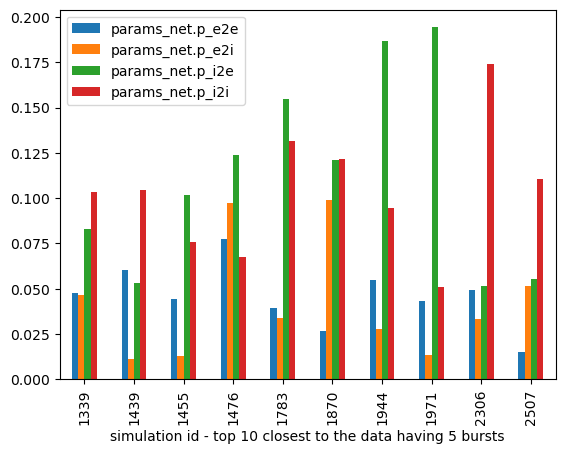

In [47]:
relevant_params= ['params_net.p_e2e', 'params_net.p_e2i', 'params_net.p_i2e', 'params_net.p_i2i']#, 'params_Ipop.poisson_rate', 'params_Epop.poisson_rate']
df_synthetic.loc[ordered.index][relevant_params].plot(kind='bar')
plt.xlabel('simulation id - top 10 closest to the data having 5 bursts')

In [24]:
# Some housekeeping to set random seed identifiers and set up simulation configurations
n_samples = 10
params_dict_run_my_try = data_utils.fill_params_dict(params_dict, df_synthetic.loc[ordered.index], posterior.as_dict, n_samples) 

#here i have to change the sim time to seconds for some readom 
for n in range(n_samples):
    params_dict_run_my_try[n]['params_settings']['sim_time'] = params_dict_run_my_try[n]['params_settings']['sim_time'] *b2.second


params_settings.batch_seed has no prior. Copied as bare value without unit.
params_settings.random_seed has no prior. Copied as bare value without unit.
params_settings.sim_time has no prior. Copied as bare value without unit.
params_settings.real_run_time has no prior. Copied as bare value without unit.
params_analysis.early_stopped has no prior. Copied as bare value without unit.


Run the simulations of chosen seeds

In [ ]:
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)

sim_parallel = True
if sim_parallel:
    from multiprocessing import Pool

    start_time = time()
    with Pool(n_samples) as pool:
        sim_collector = pool.map(runners.adex_simulator, params_dict_run_my_try)
    print(f"Simulations took {time()-start_time:.2f} seconds.")
else:
    sim_collector = []
    for i_sim in range(n_samples):
        start_time = time()
        sim_collector.append(runners.adex_simulator(params_dict_run_my_try[i_sim]))
        print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")

b2_interface.clear_b2_cache(cache_path)

cache non-existent.
7149324-53967149324-2139877149324-119740|7149324-146986||7149324-206895|7149324-220626||7149324-2248717149324-238906||7149324-241851|7149324-223974|

here you can also see that the batch seed and random seed correspond those chosen ones stored in variable 'ordered' 

### Data preprocessing
The target observation PSD has to undergo a few preprocessing steps, such as taking the log, normalizing, and re-scaling, etc. These transformations are tracked in the posterior network object (`posterior.x_bounds_and_transforms` and `posterior.x_standardizing_func`), and just need to be applied to the dataset. 

If you want to run this demo on a new dataset, you just need to replace `df_xos` with your own dataframe, where each row must contain, among other features, a PSD from 0.5 to 495Hz, at 0.5Hz frequency resolution. Alternatively, it can be supplied as a log10-PSD in a numpy array (`xo`), where only the last step is necessary (standardizing and converting to torch tensor).

 I am not using this part but it may be important ?

In [ ]:
df_xos_preproc, _, _, _ = dist_utils.preproc_dataframe_psd(
    df_xos.loc[[idx_xo]],
    posterior.x_bounds_and_transforms,
    drop_nans=False,
    replace_infs=True,
)
xo = df_xos_preproc.loc[idx_xo][cols_features].values
xo_tensor = posterior.x_standardizing_func(Tensor(xo[None, :]))
print(f"Target observation has shape {xo_tensor.shape}")

0 sims dropped due to early stopping.
0 sims dropped due to manual criteria.
0 sims dropped due to power threshold discard.
0 samples discarded in total.
Target observation has shape torch.Size([1, 990])


### Plot the discovered model simulations

In [ ]:
results_collector = [
    analysis_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector
]

WARNING    /tmp/ipykernel_3199463/1918160929.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax[1].plot(spike_train, np.ones_like(spike_train) * (2000 - neuron_id), '.k', color='C1')#, markersize=0.1)
 [py.warnings]
WARNING    /tmp/ipykernel_3199463/1918160929.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax[1].plot(spike_train, np.ones_like(spike_train) * (neuron_id), '.k', color='C0')#, markersize=0.1)
 [py.warnings]
WARNING    /tmp/ipykernel_3199463/1918160929.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data),'.k',color='darkgreen',markersize=0.01)  # Each spike as a 

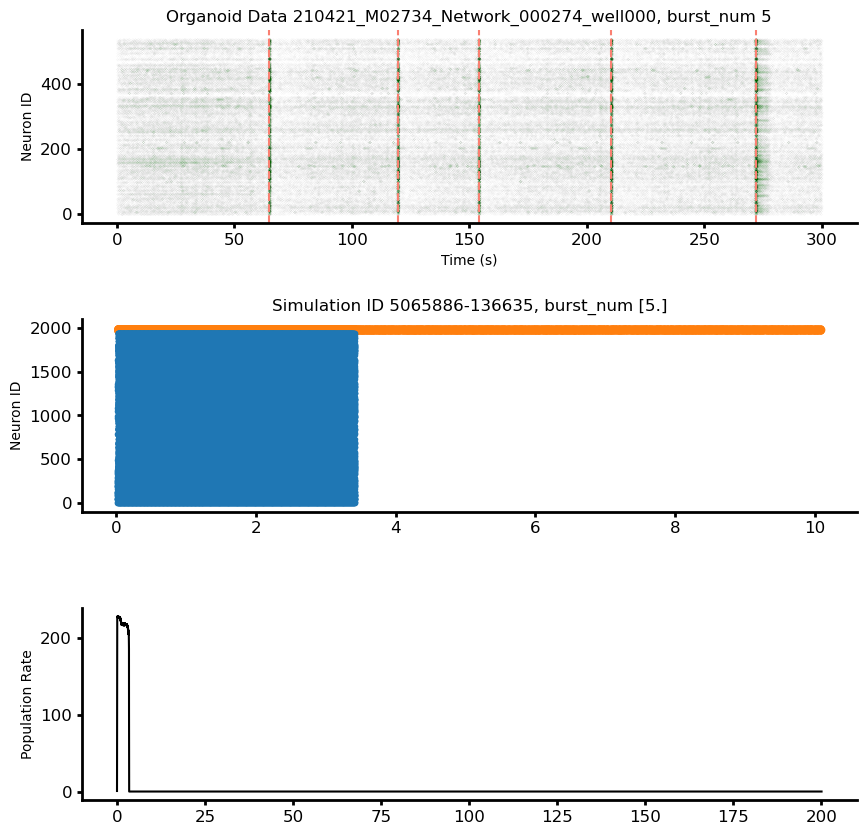

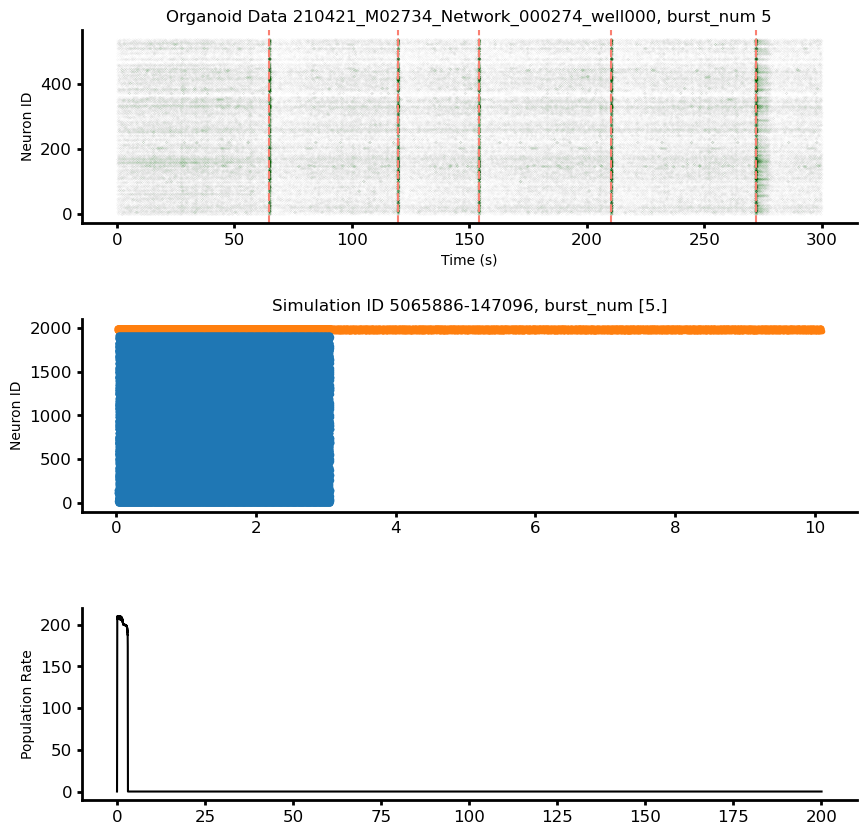

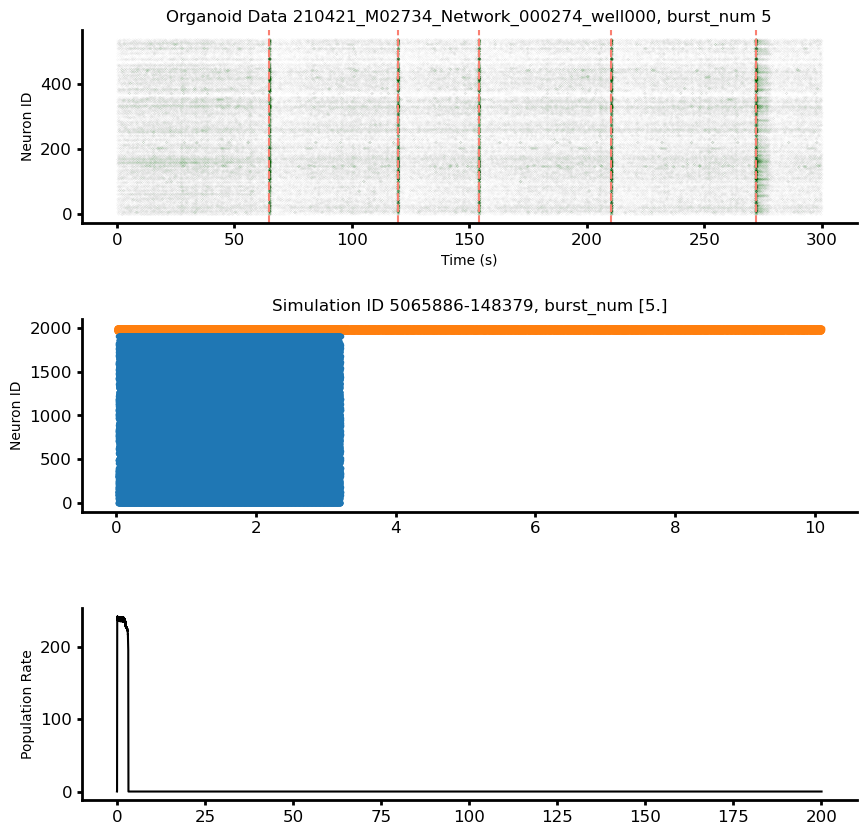

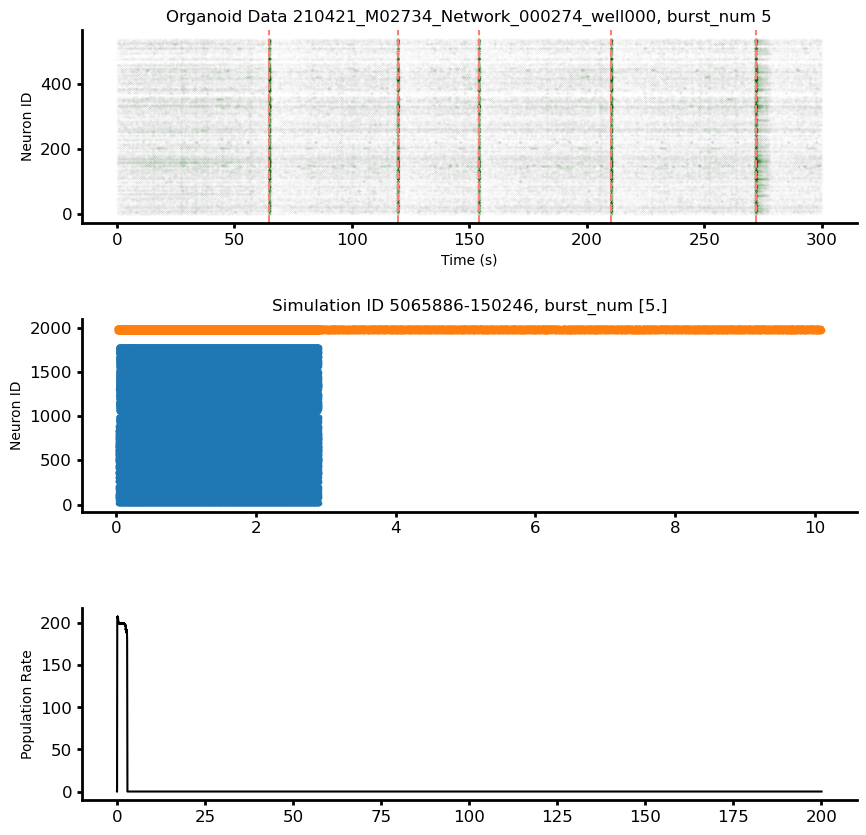

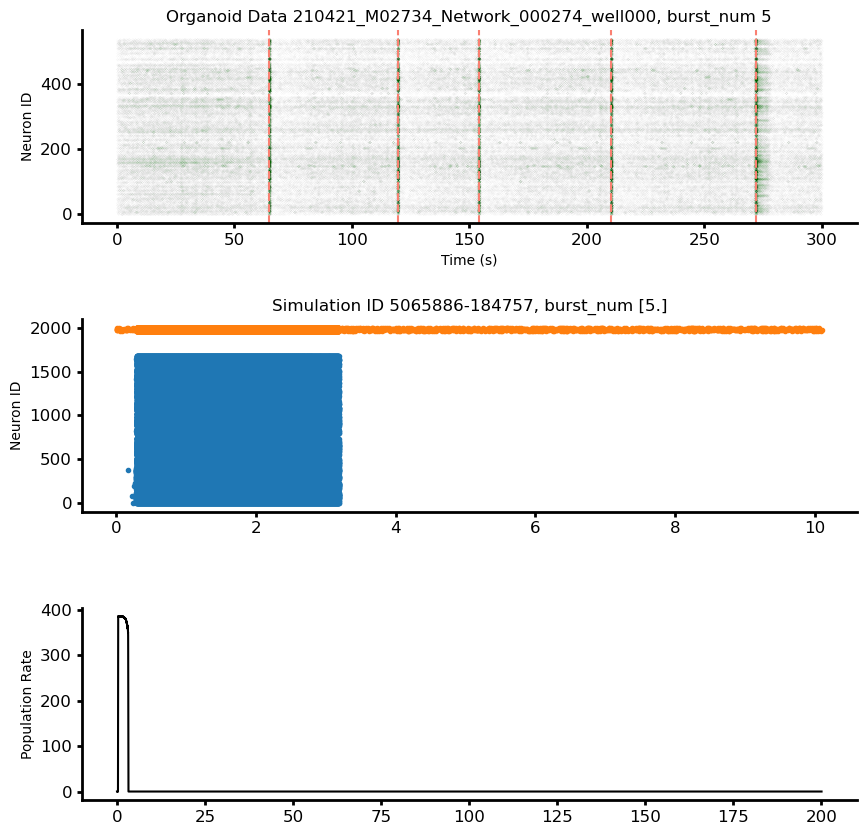

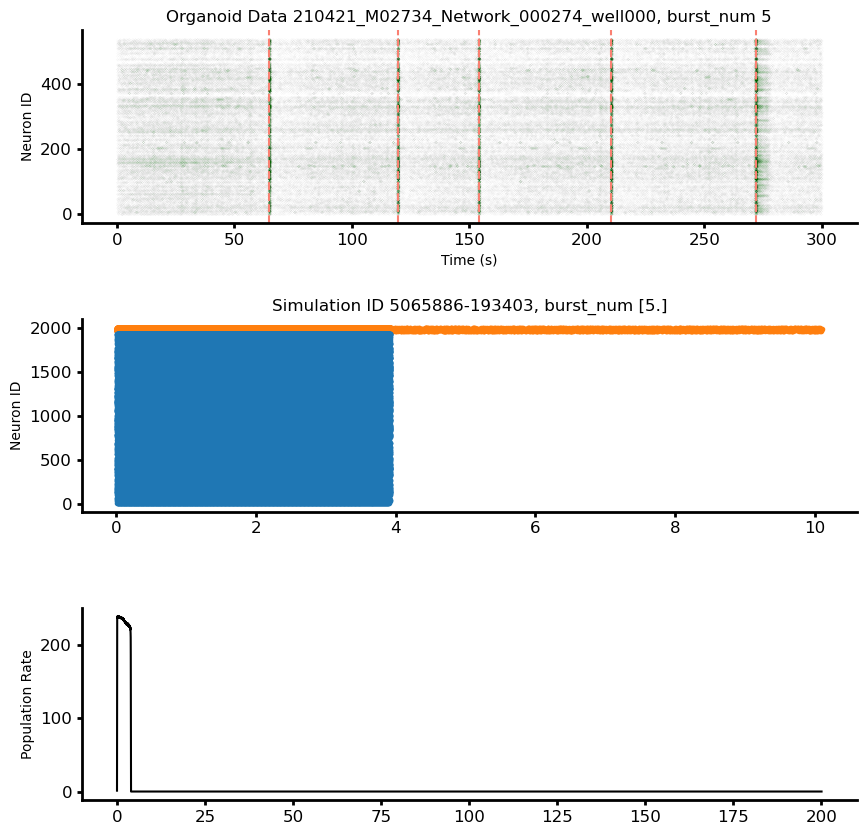

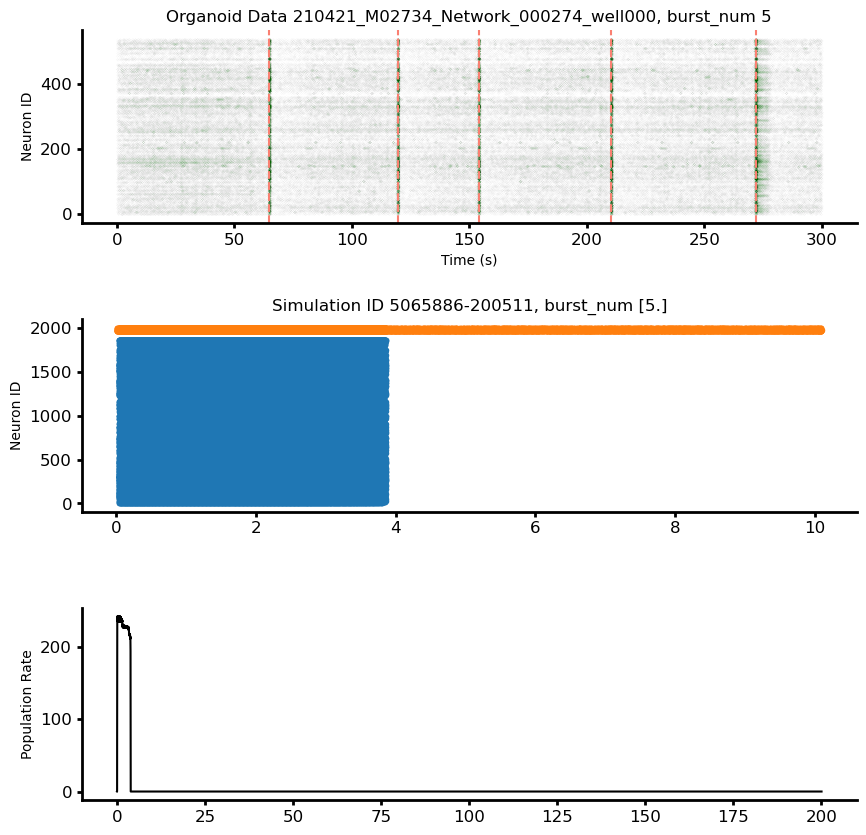

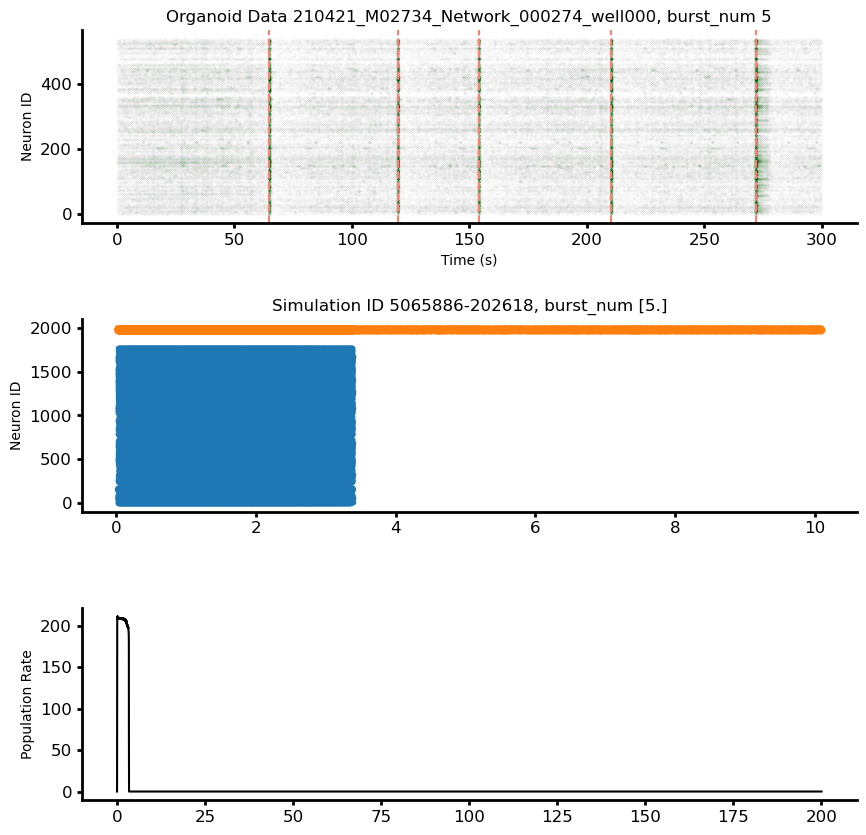

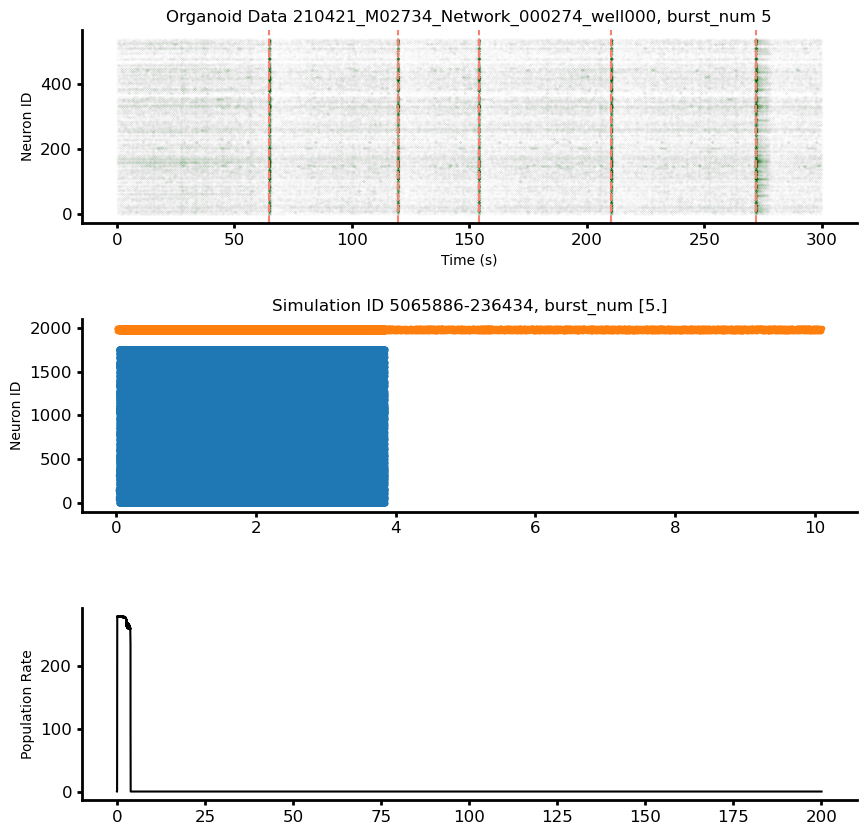

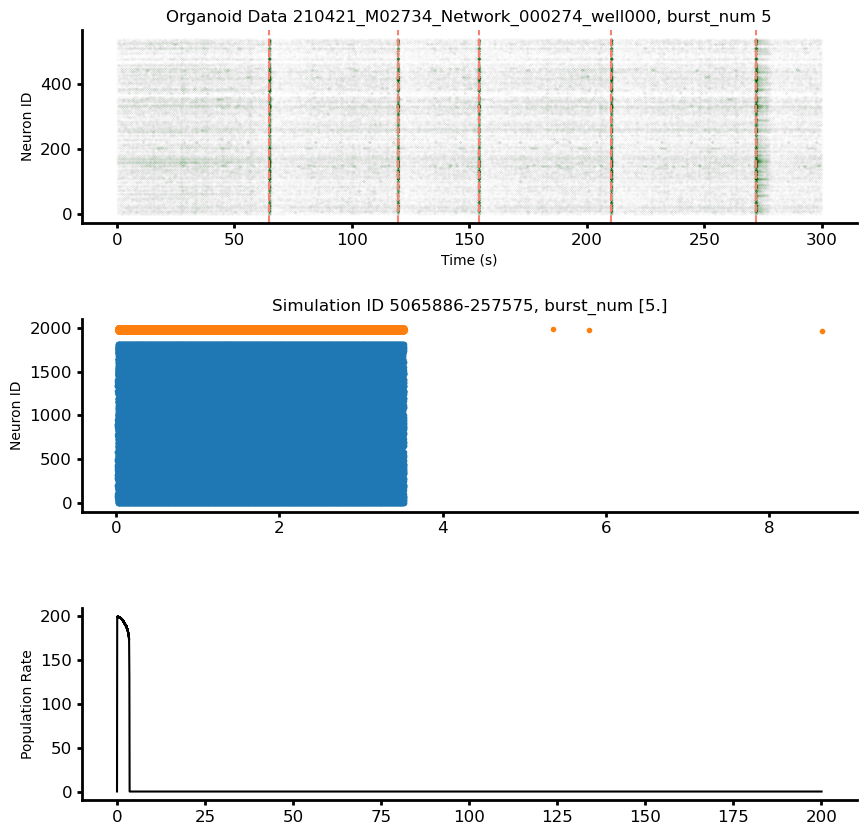

In [ ]:
# Plot the results
xlims = [0, 300]
every_other = 10

for i_sim, results in enumerate(results_collector):
    fig1, ax = plt.subplots(nrows=3, ncols=1, sharex=False,figsize=(10, 10))

    #rasters
    n_exc = int(df_synthetic['params_net.exc_prop'].iloc[0] * 2000)
    for neuron_id, spike_train in sim_collector[i_sim][1]['inh_spikes'].items():
        ax[1].plot(spike_train, np.ones_like(spike_train) * (2000 - neuron_id), '.k', color='C1')#, markersize=0.1)
    for neuron_id, spike_train in sim_collector[i_sim][1]['exc_spikes'].items():
        ax[1].plot(spike_train, np.ones_like(spike_train) * (neuron_id), '.k', color='C0')#, markersize=0.1)
    
    ax[1].set_ylabel("Neuron ID")
    ax[1].set_title("Simulation ID {}-{}, burst_num {}".format(sim_collector[i_sim][0]['params_settings']['batch_seed'],sim_collector[i_sim][0]['params_settings']['random_seed'],df_synthetic.loc[ordered.index, ['burst_num']].values[i_sim]))

    #pop average rates
    ax[2].plot(results_collector[i_sim]["pop_rates"]["t_ds"], results_collector[i_sim]["pop_rates"]["avgpop_rate"], "k")
    ax[2].set_ylabel("Population Rate")
    

    #data
    
    for neuron_id_data,spike_train in data.items(): 
        spike_times = spike_train[spike_train <= 300]  # Filter spike times to 200 seconds
        ax[0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data),'.k',color='darkgreen',markersize=0.01)  # Each spike as a vertical line

        # Formatting the plot
        ax[0].set_xlabel("Time (s)")
        ax[0].set_ylabel("Neuron ID")
    for burst in data_analysis[2]['burst_times']:
        ax[0].axvline(x=burst, color='salmon', linestyle='--')

    ax[0].set_title("Organoid Data {}, burst_num {}".format(data_info['key'],data_analysis[0]['burst_num'].iloc[0]))
    # Formatting the plot
    for axis in ax:
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['left'].set_linewidth(2)
        axis.spines['bottom'].set_linewidth(2)
        axis.tick_params(width=2,labelsize=12)
    # Adjust the space between subplots
    plt.subplots_adjust(hspace=0.5)



# Run the analysis again
and see what we get in not really consistent with what I should get... 

In [ ]:
#run the data analysis on these 10 simulations and find if they really have 3 bursts
for i_sim, results in enumerate(results_collector):
    data_analysis_after = analysis_utils.compute_spike_burst_features({'exc_spikes':sim_collector[i_sim][1]['exc_spikes'],'t_end':200.1}, params_dict) #does having the wrong params_dict matter?
    #print(data_analysis_after[0].keys())  # Print the keys to understand the structure
    if 'burst_num' in data_analysis_after[0]:
        print(i_sim,' ',data_analysis_after[0]['burst_num'].values)
    else:
        print(i_sim,' ',"Key 'burst_num' not found in the analysis results.")


0   Key 'burst_num' not found in the analysis results.
1   Key 'burst_num' not found in the analysis results.
2   Key 'burst_num' not found in the analysis results.
3   Key 'burst_num' not found in the analysis results.
4   Key 'burst_num' not found in the analysis results.
5   Key 'burst_num' not found in the analysis results.
6   Key 'burst_num' not found in the analysis results.
7   Key 'burst_num' not found in the analysis results.
8   Key 'burst_num' not found in the analysis results.
9   Key 'burst_num' not found in the analysis results.
